# CoxPH-EWAS unadjusted in COG trials with OS and EFS as outcome

```{contents}
```

## Load data

In [2]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'


df_methyl = pd.read_pickle(
    input_path+'df_batch_uncorrected.pkl').sort_index()

df_labels = pd.read_csv(
    input_path+'clinical_data.csv', index_col=0, low_memory=False).sort_index()

print(
    f' Dataset (df) contains {df_methyl.shape[1]} columns (5mC nucleotides/probes) and {df_methyl.shape[0]} rows (samples).')

 Dataset (df) contains 333352 columns (5mC nucleotides/probes) and 3330 rows (samples).


## Remove samples based on certain clinical features

### Select samples from AAML1031, 0531, and 03P1 clinical trials

In [3]:
df1 = df_labels[df_labels['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]

print(
    f'{df_labels.shape[0]-df1.shape[0]} samples were removed. {df1.shape[0]} samples remaining.')


2049 samples were removed. 1281 samples remaining.


### Select diagnostic bone marrow samples only

In [4]:
df2 = df1[df1['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow'])]

print(
    f'{df1.shape[0]-df2.shape[0]} samples were removed. {df2.shape[0]} samples remaining.')

350 samples were removed. 931 samples remaining.


### Remove duplicate samples

In [5]:
df3 = df2[~df2['Patient_ID'].duplicated(keep='last')]

print(
    f'{df2.shape[0]-df3.shape[0]} samples were removed. {df3.shape[0]} samples remaining.')


7 samples were removed. 924 samples remaining.


### Match samples in clinical data to samples in methylation data

In [6]:
# Match samples in clinical data to samples in methylation data
df_methyl_filtered = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 1:]

print('Samples in clinical data matched to samples in methylation data.')

Samples in clinical data matched to samples in methylation data.


## Transform to M-values

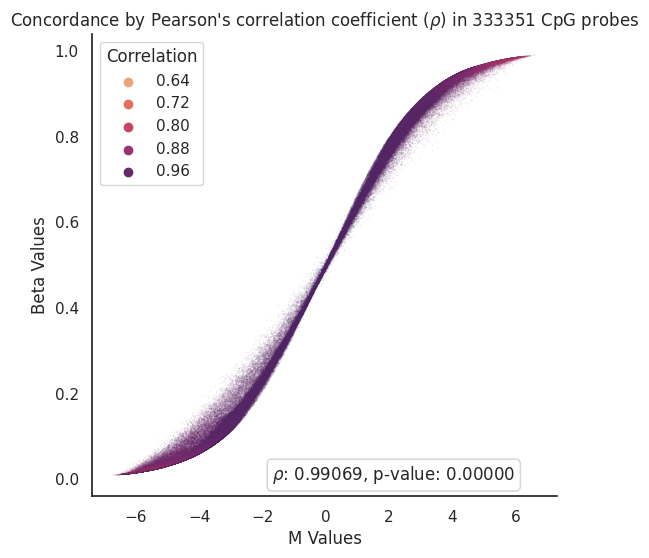

In [7]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_train_m = df_methyl_filtered.apply(np.vectorize(beta2m))

# Get correlation between Beta and M Values
corr = x_train_m.corrwith(df_methyl_filtered, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_train_m.mean(),df_methyl_filtered.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.1,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    # plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
    #              bbox_inches='tight', dpi=300)

    return(plt.show())

draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=1)

## Perform batch correction

- __pyCombat__ is a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Preprint__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Adjusting batch effects in microarray expression data using empirical Bayes methods](https://pubmed.ncbi.nlm.nih.gov/16632515/)

In [8]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df_batchcorrected = pycombat(data = x_train_m.T, batch = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]).round(3).T

print('Succesfully corrected batch effects in the training dataset.')


Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

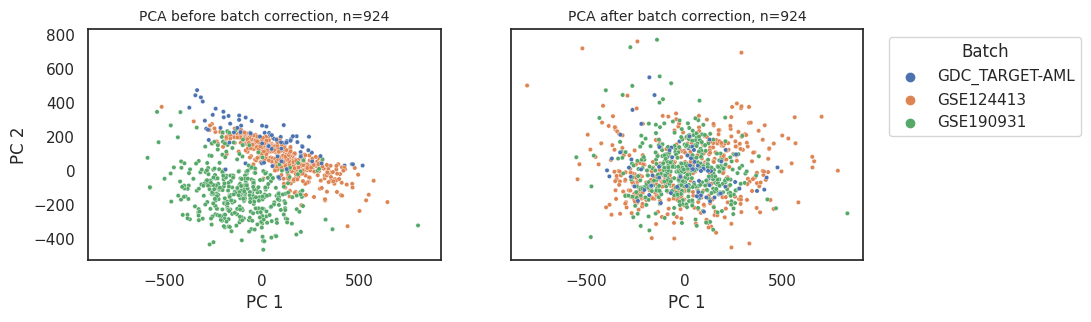

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df.columns)
    principal_df['hue'] = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

X_std = standardize_data(df_batchcorrected.T)
principal_components = perform_pca(X_std)
pcs_batchcorrected = create_principal_df(principal_components, df_batchcorrected.T)

X_std = standardize_data(x_train_m.T)
principal_components = perform_pca(X_std)
pcs_uncorrected = create_principal_df(principal_components, x_train_m.T)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(pcs_batchcorrected, pcs_uncorrected)


## Run CoxPH-EWAS OS

### Unadjusted

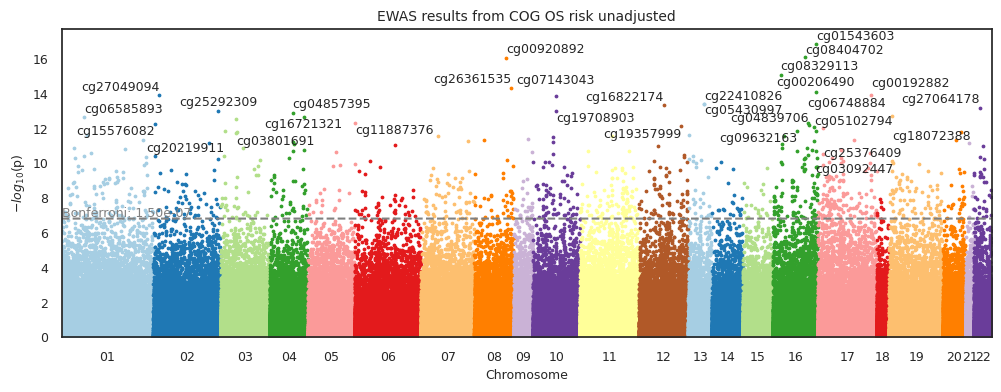

In [10]:
import methylize
import seaborn as sns
sns.set_theme(style="white")

# ewas_os_cog_unadjusted = methylize.diff_meth_pos(meth_data = df_batchcorrected,
#                                     duration = df3['os.time'],
#                                     event_observed = df3['os.evnt'],
#                                     pheno_data = df3['os.time'], # not used
#                                     covariates = False,
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = True,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_os_batch_corrected')

ewas_os_cog_unadjusted = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_os_batch_corrected_risk_unadjusted.pkl')

methylize.manhattan_plot(stats_results=ewas_os_cog_unadjusted,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG OS risk unadjusted",
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')


### Risk group adjusted

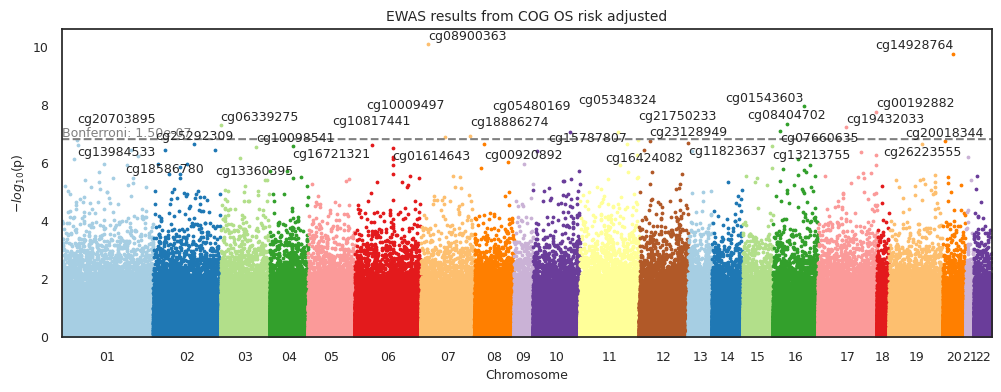

In [11]:
df3 = df3.assign(Risk_Group_Bin=df3['Risk Group'].map({'Low Risk':0, 'Standard Risk':0.5,'High Risk':1}))

def impute_by_mean(df):
    '''Impute missing values by computing feature average'''
    return df.fillna(df.mean())

covar_os = round(impute_by_mean(df3[['os.evnt','os.time','Risk_Group_Bin']]),3)

# ewas_os_cog_adjusted = methylize.diff_meth_pos(meth_data = df_batchcorrected,
#                                     duration = covar_os['os.time'],
#                                     event_observed = covar_os['os.evnt'],
#                                     pheno_data = covar_os['os.time'], # not used
#                                     covariates = covar_os['Risk_Group_Bin'],
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = False,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_os_batch_corrected_risk_adjusted')

ewas_os_cog_adjusted = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_os_batch_corrected_risk_adjusted.pkl')

methylize.manhattan_plot(stats_results=ewas_os_cog_adjusted,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG OS risk adjusted",
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')

## Run CoxPH-EWAS EFS

### Unadjusted

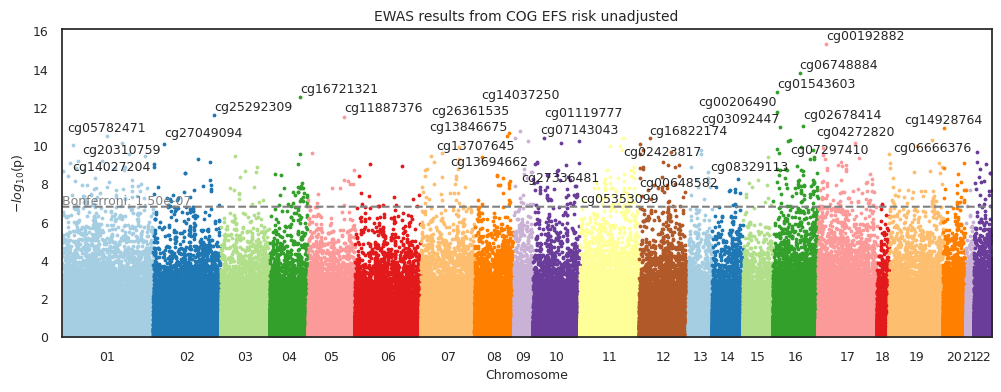

In [12]:
import methylize
import seaborn as sns
sns.set_theme(style="white")

# ewas_efs_cog_unadjusted = methylize.diff_meth_pos(meth_data = df_batchcorrected,
#                                     duration = df3['efs.time'],
#                                     event_observed = df3['efs.evnt'],
#                                     pheno_data = df3['efs.time'], # not used
#                                     covariates = False,
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = True,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_efs_batch_corrected')

ewas_efs_cog_unadjusted = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_efs_batch_corrected_risk_unadjusted.pkl')

methylize.manhattan_plot(stats_results=ewas_efs_cog_unadjusted,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG EFS risk unadjusted",
                        filename='../Figures/Manhattan_Plots/ewas_efs_unadjusted')


### Risk group adjusted

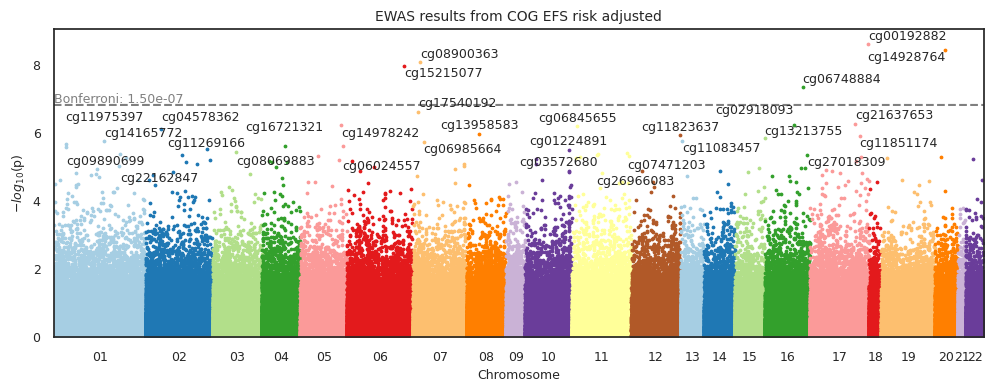

In [13]:
df3 = df3.assign(Risk_Group_Bin=df3['Risk Group'].map({'Low Risk':0, 'Standard Risk':0.5,'High Risk':1}))

def impute_by_mean(df):
    '''Impute missing values by computing feature average'''
    return df.fillna(df.mean())

covar_efs = round(impute_by_mean(df3[['efs.evnt','efs.time','Risk_Group_Bin']]),3)

# ewas_efs_cog_adjusted = methylize.diff_meth_pos(meth_data = df_batchcorrected,
#                                     duration = covar_efs['efs.time'],
#                                     event_observed = covar_efs['efs.evnt'],
#                                     pheno_data = covar_efs['efs.time'], # not used
#                                     covariates = covar_efs['Risk_Group_Bin'],
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = False,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_efs_batch_corrected_risk_adjusted')

ewas_efs_cog_adjusted = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_efs_batch_corrected_risk_adjusted.pkl')

methylize.manhattan_plot(stats_results=ewas_efs_cog_adjusted,
                        palette='Paired',
                        save=False,
                        suggestive=False,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=True,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=True,
                        fwer=0.05,
                        cohorts= " COG EFS risk adjusted",
                        filename='../Figures/Manhattan_Plots/ewas_efs_adjusted')

## Select statistically significant CpGs

### Threshold based on Bonferroni-corrected p-values (1.5*10e-7)

In [14]:
def select_rows(df, threshold):
    return df[df['PValue'] < threshold]

def get_intersection(df1, df2):
    return df1[df1.index.isin(df2.index)]

# store the dataframes in a dictionary
data_dict = {
    'Unadjusted': {
        'os': ewas_os_cog_unadjusted,
        'efs': ewas_efs_cog_unadjusted,
    },
    'Adjusted': {
        'os': ewas_os_cog_adjusted,
        'efs': ewas_efs_cog_adjusted,
    }
}

# empty dictionary to store the results
results = {}

# loop through the data_dict
for condition, dfs in data_dict.items():
    top_dfs = {key: select_rows(df, 0.05/df.shape[0]) for key, df in dfs.items()}
    intersection = get_intersection(top_dfs['os'], top_dfs['efs'])

    results[condition] = {
        'os': top_dfs['os'].shape[0],
        'efs': top_dfs['efs'].shape[0],
        'intersection': intersection.shape[0],
    }

# convert results to a pandas DataFrame and display
result_df = pd.DataFrame(results).T
result_df.columns = ['Significant CpG probes in OS', 
                    'Significant CpG probes in EFS',
                    'Significant overlapping CpG probes']
result_df


,Significant CpG probes in OS,Significant CpG probes in EFS,Significant overlapping CpG probes
Unadjusted,1076,593,418
Adjusted,12,5,3


#### Fetch genes

In [15]:
# Define a function to handle repetitive tasks
def process_df(df, other_df, column_drop):
    # Join and sort values
    df = df.join(other_df.drop(columns=column_drop), how='inner').sort_values(by='PValue')

    # Handle columns with multiple genes separated by `;`
    for col in ['GeneNames', 'GeneClasses']:
        df[col] = df[col].apply(lambda x: ';'.join(set(x.split(';'))))

    return df

# Load manifest
zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv',
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames',
                                                     'GeneClasses','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
top_efs = process_df(zhou2016_probes, top_dfs['efs'], ['chromosome', 'MAPINFO'])
top_os = process_df(zhou2016_probes, top_dfs['os'], ['chromosome', 'MAPINFO'])

#### OS Bonferroni-significant probes:

In [16]:
from itables import show

show(top_os, classes="display nowrap cell-border", paging=False)

#### EFS Bonferroni significant probes:

In [17]:
show(top_efs, classes="display nowrap cell-border", paging=False)

### Threshold based on suggested-significance p-values (1*10e-6)

In [18]:
def select_rows(df, threshold):
    return df[df['PValue'] < threshold]

def get_intersection(df1, df2):
    return df1[df1.index.isin(df2.index)]

# store the dataframes in a dictionary
data_dict = {
    'Unadjusted': {
        'os': ewas_os_cog_unadjusted,
        'efs': ewas_efs_cog_unadjusted,
    },
    'Adjusted': {
        'os': ewas_os_cog_adjusted,
        'efs': ewas_efs_cog_adjusted,
    }
}

# empty dictionary to store the results
results = {}

# loop through the data_dict
for condition, dfs in data_dict.items():
    top_dfs = {key: select_rows(df, 1*10e-6) for key, df in dfs.items()}
    intersection = get_intersection(top_dfs['os'], top_dfs['efs'])

    results[condition] = {
        'os': top_dfs['os'].shape[0],
        'efs': top_dfs['efs'].shape[0],
        'intersection': intersection.shape[0],
    }

# convert results to a pandas DataFrame and display
result_df = pd.DataFrame(results).T
result_df.columns = ['Significant CpG probes in OS', 
                    'Significant CpG probes in EFS',
                    'Significant overlapping CpG probes']
result_df


,Significant CpG probes in OS,Significant CpG probes in EFS,Significant overlapping CpG probes
Unadjusted,3740,2634,1741
Adjusted,167,55,17


#### Fetch genes

In [19]:
# Define a function to handle repetitive tasks
def process_df(df, other_df, column_drop):
    # Join and sort values
    df = df.join(other_df.drop(columns=column_drop), how='inner').sort_values(by='PValue')

    # Handle columns with multiple genes separated by `;`
    for col in ['GeneNames', 'GeneClasses']:
        df[col] = df[col].apply(lambda x: ';'.join(set(x.split(';'))))

    return df

# Load manifest
zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv',
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames',
                                                     'GeneClasses','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
top_efs = process_df(zhou2016_probes, top_dfs['efs'], ['chromosome', 'MAPINFO'])
top_os = process_df(zhou2016_probes, top_dfs['os'], ['chromosome', 'MAPINFO'])

#### OS Bonferroni-significant probes:

In [20]:
from itables import show

show(top_os, classes="display nowrap cell-border")

#### EFS Bonferroni significant probes:

In [21]:
show(top_efs, classes="display nowrap cell-border")

## Standardize and save top probes (adjusted OS at 1*10e-6)

In [22]:
# Select only significant probes
x = df_batchcorrected[top_os.index.to_list()]

# Standardize the data
x = (x - x.mean()) / x.std()

# Save x to pickle in output_path
x.to_pickle(output_path + 'ewas_dmr/ewas_top_x.pkl')

# Print a statement saying that you have saved the data, the shape and the path
print('Succesfully saved the data in ' + output_path + 'ewas_dmr/ewas_top_x.pkl')
print('The shape of the data is ' + str(x.shape))

Succesfully saved the data in ../Data/Processed_Data/ewas_dmr/ewas_top_x.pkl
The shape of the data is (924, 167)


## Watermark

In [23]:
%load_ext watermark

In [24]:
%watermark -v -p methylize,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

methylize: 1.1.1
pandas   : 2.0.1

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

